# Assignment 1: Python Basics

Proteins are clustered into families based on sequence similarity. A protein family is a group of proteins that share a common evolutionary origin, reflected by their related functions and similarities in sequence or structure. Sequences of proteins in a family are aligned to identify the conserved regions and the variations in the family. Such an alignment is called a multiple sequence alignment (MSA).

In this assignment, you will write Python code to process the MSA of a protein family. The MSA is stored in a text file in the [Stockholm format](https://en.wikipedia.org/wiki/Stockholm_format). The Stockholm formatted file looks like the following:

```
# STOCKHOLM 1.0
#=GF ID   EXAMPLE
<seqname> <aligned sequence>
<seqname> <aligned sequence>
<seqname> <aligned sequence>
//
```

The first line shows the version of the Stockholm format. Each line that starts with `#` is a comment and can be ignored. It is followed by the aligned sequences of the proteins in the family, one sequence per line. Each line contains the sequence name (including start and end positions) and the aligned sequence separated by spaces. The alignment is ended by `//`.

First, let us download a sample MSA file that we will use for this assignment. The following code downloads the MSA of the [protein family PF00041](https://www.ebi.ac.uk/interpro/entry/pfam/PF00041/) from the Pfam database and saves it to the file `PF00041_seed.txt` in the folder `data`. Within the protein sequence, letters represent the amino acids (e.g., `A` for Alanine, `C` for Cysteine, etc.), and `-` and `.` are gaps. 


In [3]:
import urllib3
import gzip
import math
import matplotlib.pyplot as plt

pfam_id = "PF00041"
http = urllib3.PoolManager()
r = http.request(
    "GET",
    f"https://www.ebi.ac.uk/interpro/wwwapi//entry/pfam/{pfam_id}/?annotation=alignment:seed&download",
)
data = gzip.decompress(r.data)
data = data.decode()
with open(f"./data/{pfam_id}_seed.txt".format(pfam_id), "w") as file_handle:
    print(data, file=file_handle)

You can open the file `PF00041_seed.txt` in a text editor to see the content of the MSA file. In the following, you will write Python code to read this file and process the MSA .

## 1. Reading the MSA file

1. Read the MSA file `PF00041_seed.txt` and store the sequences in a dictionary. The key of each item in the dictionary is the sequence name, and the value is the aligned sequence as a string. The sequence name should include the start and end positions of the sequence if provided. If the start and end positions are not provided, you can use the sequence name as it is. Keep the gaps in the aligned sequences.

2. Write a function to get the names of sequences that are longer than 100 amino acids, excluding gaps. Use the dictionary created in the previous step as input to this function. The function should return a list of sequence names

In [4]:
## msa is the dictionary that will store the MSA
msa = {}
with open(f"./data/{pfam_id}_seed.txt", "r") as file_handle:
    for line in file_handle:
        ######################################################################
        ## write code to parse the MSA file and store it in the dictionary msa

        if line.startswith("#"):
            continue
        if line.startswith("//"):
            break

        line = line.strip().split()
        if len(line) == 0:
            continue

        name = line[0]
        seq = line[1]
        msa[name] = seq

        ######################################################################

In [5]:
def get_names_of_long_sequences(msa: dict) -> int:
    """
    This function get names of sequences that are longer than
    100 amino acids
    """
    ####################################################################
    ## write your code here

    names = []
    for n, seq in msa.items():
        s = seq.replace(".", "")
        if len(s) > 100:
            names.append(n)

    return names
    ####################################################################

In [6]:
names = get_names_of_long_sequences(msa)
print(f"Names of sequences longer than 100 amino acids: {names}")

Names of sequences longer than 100 amino acids: ['KALM_CHICK/544-647', 'EPHB2_CHICK/327-428', 'EPHA3_CHICK/326-427', 'EPHA1_HUMAN/334-437']


## 2. Processing the MSA
The sequence `EPHA1_HUMAN/334-437` is one of the sequences obtained from the previous step. In this part, you will used this sequence as a reference sequence to process the MSA.

Write a function that takes the reference sequence name and the msa dictionary as input and processes the MSA as follows. First, for each sequence, remove the positions that have a gap in the reference sequence. In other words, if the reference sequence has a gap at a position, remove that position from all the sequences. Second, for each position, remove the position from all the sequences if more than 80% of the sequences have a gap at that position. The function should return a new dictionary with the processed sequences.

In [7]:
def process_msa(reference: str, msa: dict) -> dict:
    ####################################################################
    ## write your code here

    ref_seq = msa[reference]
    pos = [a for a in range(len(ref_seq)) if ref_seq[a] != "."]

    msa_processed = {}
    for n, seq in msa.items():
        msa_processed[n] = "".join([seq[a] for a in pos])

    gaps_per_position = []
    for j in range(len(pos)):
        n = 0
        for v in msa_processed.values():
            if v[j] == ".":
                n += 1
        gaps_per_position.append(n)

    pos = [
        j
        for j in range(len(gaps_per_position))
        if gaps_per_position[j] < 0.2 * len(msa_processed)
    ]

    for k in msa_processed.keys():
        msa_processed[k] = "".join([msa_processed[k][a] for a in pos])

    return msa_processed


In [8]:
msa_processed = process_msa("EPHA1_HUMAN/334-437", msa)

## 3 Calculating Shannon Entropy
For each position in the processed MSA, we are interested in knowing how conserved it is, i.e., the degree of variation at that position. A commonly used measure for this is the Shannon entropy. The Shannon entropy is calculated as follows:
$$H = -\sum_{i=1}^{21} p_i \log_2(p_i)$$
where $p_i$ is the frequency of the $i$-th amino acid at that position. $i$ ranges from 1 to 21 because there are 20 amino acids and we consider the gap as an additional character. When $p_i = 0$ for an amino acid, the term $p_i \log(p_i)$ is taken as 0. The entropy value ranges from 0 (no variation) to $\log_2(21) \approx 4.39$ (all amino acids are equally likely). 

Write a function that takes the processed MSA dictionary as input and calculates the Shannon entropy for each position in the MSA. The function should return a list of entropy values, one for each position in the MSA. You could write additional helper functions to be used in this function if necessary.

In [9]:
def get_amino_acids(pos: int, msa: dict) -> dict:
    aa = []
    for s in msa.values():
        aa.append(s[pos])
    return aa

def compute_freq(aas: list) -> dict:
    freq = {}
    for a in aas:
        if a in freq:
            freq[a] += 1
        else:
            freq[a] = 1
    for a in freq.keys():
        freq[a] /= len(aas)
    return freq

def compute_entropy(freq: dict) -> float:
    entropy = 0
    for a in freq.keys():
        entropy -= freq[a] * math.log2(freq[a])

    return entropy

def compute_entropy_mas(msa: dict) -> dict:
    entropy = []
    for i in range(len(list(msa.values())[0])):
        aa = get_amino_acids(i, msa)
        freq = compute_freq(aa)
        entropy.append(compute_entropy(freq))

    return entropy

entropy = compute_entropy_mas(msa_processed)


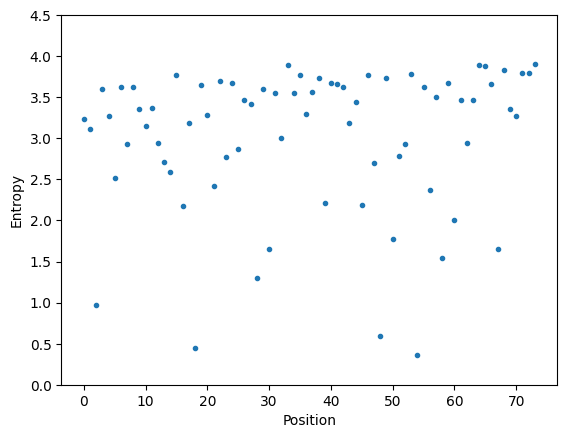

In [14]:
fig = plt.figure()
plt.clf()
plt.plot(entropy, '.')
plt.ylim([0, 4.5])
plt.xlabel("Position")
plt.ylabel("Entropy")
plt.show()